In [30]:
# imports
%matplotlib inline
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
import numpy as np
import pandas as pd
import glob

# Triploid asexuals

## utility functions

In [2]:
def get_scaled_ts(result):
    i = 0
    ts = []
    while True:
        tstr = 't{}'.format(i)
        if tstr in result:
            ts.append(result[tstr])
        else:
            break
        i += 1
    return np.array(ts)

def get_lambdas(result):
    i = 0
    lambdas = []
    while True:
        tstr = 'lambda{}'.format(i)
        if tstr in result:
            lambdas.append(result[tstr])
        else:
            break
        i += 1
    return np.array(lambdas)

def get_N0(result, mu, blockLen):
    theta = result['theta']
    N0 = theta / (4.0*mu*blockLen)
    return N0

def get_Ns(result, mu, blockLen):
    N0 = get_N0(result, mu, blockLen)
    lambdas = get_lambdas(result)
    Ns = N0*lambdas
    return Ns

def get_unscaled_divtime(result, mu, blockLen):
    N0 = get_N0(result, mu, blockLen)
    divtime = result['divtime']
    if divtime is None:
        return None
    unscaledDivtime = divtime * (2.0*N0)
    return unscaledDivtime
    
def get_unscaled_ts(result, mu, blockLen):
    scTs = get_scaled_ts(result)
    N0 = get_N0(result, mu, blockLen)
    unscaledTs = 2.0*N0*scTs
    return unscaledTs

In [3]:
def read_tsmc_results(filename):
    results = {}
    results['divtime'] = None  # divtime None by default...
    fin = open(filename,'r')
    for line in fin:
        line = line.strip()
        spline = line.split('\t')
        if line[:2] == 'LR':
            results['loglike'] = float(spline[1])
            continue
        if line[:2] == 'PA':
            paramstr = spline[1]
            if paramstr == 'rho':
                results['rho'] = float(spline[2])
            if paramstr == 'theta':
                results['theta'] = float(spline[2])
            if paramstr[:3] == 'lam':
                whichLam = int(paramstr[3:])
                results['lambda{}'.format(whichLam)] = float(spline[3])
                results['t{}'.format(whichLam)] = float(spline[2])
            if paramstr[:2] == 'Td':
                results['divtime'] = float(spline[2])
    return results

In [4]:
def plot_psmc(axis, ts, lambdas, divtime = None, maxt = None, logN = True, logT = False, **plotkwargs):
    newTs = np.repeat(np.array(ts), 2)[1:]
    newLambdas = np.repeat(np.array(lambdas), 2)[:-1]
    if divtime is None:
        axis.plot(newTs, newLambdas, '-', **plotkwargs)
    else:
        baseline, = axis.plot(newTs+divtime, newLambdas, '-', **plotkwargs)
        if 'color' not in plotkwargs:
            axis.axvline(x = divtime, color = baseline.get_color(), **plotkwargs)
        else:
            axis.axvline(x = divtime, **plotkwargs)
    if maxt is not None:
        axis.set_xlim((0, maxt))
    if logT:
        axis.set_xscale('log')
    if logN:
        axis.set_yscale('log')
    return

In [5]:
def read_tsmc_convergence(filename):
    results = {}
    results['divtime'] = []  # divtime None by default...
    fin = open(filename,'r')
    for line in fin:
        line = line.strip()
        spline = line.split('\t')
        if line[:2] == 'LR':
            if 'loglike' not in results:
                results['loglike'] = []
            results['loglike'].append(float(spline[1]))
            continue
        if line[:2] == 'PA':
            paramstr = spline[1]
            if paramstr == 'rho':
                if 'rho' not in results:
                    results['rho'] = []
                results['rho'].append(float(spline[2]))
            if paramstr == 'theta':
                if 'theta' not in results:
                    results['theta'] = []
                results['theta'].append(float(spline[2]))
            if paramstr[:3] == 'lam':
                whichLam = int(paramstr[3:])
                lam = 'lambda{}'.format(whichLam)
                t = 't{}'.format(whichLam)
                if lam not in results:
                    results[lam] = []
                results[lam].append(float(spline[3]))
                if t not in results:
                    results[t] = []
                results[t].append(float(spline[2]))
            if paramstr[:2] == 'Td':
                if 'divtime' not in results:
                    results['divtime'] = []
                results['divtime'].append(float(spline[2]))
    return results

## constant population size with asex

In [23]:
mu = 1.5e-8  # mutation rate
r = 1.0e-8  # recombination rate
N = 10000  # diploid population size in the sexual ancestor
chromLength = int(1e7)  # 10 Mbp per chromosome
#numChromosomes = 100  # simulate 100 chromosomes per replicate
numChromosomes = 10  # simulate 10 chromosomes per replicate

# scaled parameters for entire chromosomes
rho = 4*N*r*chromLength
theta = 4*N*mu*chromLength

# the different transition times to test
asexGens = np.array([2000, 5000, 10000, 20000, 40000])
asexGensRescaled = asexGens / (2.0*N)  # rescaled by 2*N

In [24]:
msCmd = "mspms 3 {numChroms} -r {rho} {chromLen} -t {theta} -p 10".format(
    numChroms = numChromosomes,
    chromLen = chromLength,
    rho = rho,
    theta = theta)

In [25]:
msCmd

'mspms 3 10 -r 4000.0 10000000 -t 6000.0 -p 10'

In [26]:
float(rho)/chromLength*100

0.04

In [31]:
# with 0.5 asex gens

divtimes = [0.25, 0.5, 1.0]

numReps = 5

msCmd = "mspms 3 {numChroms} -r {rho} {chromLen} -t {theta} -p 10".format(
    numChroms = numChromosomes,
    chromLen = chromLength,
    rho = rho,
    theta = theta)

addAsexCmds = ["./add_asex.py --triploid - {}".format(divtime) for divtime in divtimes]

filenames = ['triploid_const_N_asex_{asex}.txt'.format(asex = divtime) for divtime in divtimes]

resultsfilenames = ['triploid_const_N_asex_{asex}.results'.format(asex = divtime) for divtime in divtimes]


In [32]:
ms2tsmcfaCmd = "./ms2psmcfa.py"

In [45]:
fullCmds = ["{} | {} | {} > {}".format(msCmd, asexCmd, ms2tsmcfaCmd, filename) for asexCmd, filename in zip(addAsexCmds, filenames)]
fullCmdsReps = []
resultsFilenamesReps = []
for divtime in divtimes:
    asexCmd = "./add_asex.py --triploid - {}".format(divtime)
    for rep in xrange(1,numReps+1):
        filename = 'triploid_const_N_asex_{asex}_rep{rep}.txt'.format(asex = divtime, rep = rep)
        resultsfilename = 'triploid_const_N_asex_{asex}_rep{rep}.results'.format(asex = divtime, rep = rep)
        resultsFilenamesReps.append(resultsfilename)
        fullCmdsReps.append("{} | {} | {} > {}".format(msCmd, asexCmd, ms2tsmcfaCmd, filename))

In [47]:
#with open('tsmc/triploid_const_asex_data_generation_cmds', 'w') as generationFout:
#    for fullCmd in fullCmds:
#        generationFout.write(fullCmd + '\n')
#with open('results/triploid_const_asex_data_generation_cmds_reps', 'w') as generationFout:
#    for fullCmd in fullCmdsReps:
#        generationFout.write(fullCmd + '\n')

In [49]:
pattern = "4*4"
iterations = 50
iterationsReps = 20

In [52]:
analysisCmds = ['stdbuf -o0 -e0 -i0 ./tsmc -p {pattern}  -i {iterations} {filename} > {resultsfilename}'.format(
    pattern = pattern,
    iterations = iterations,
    filename = filename,
    resultsfilename = resultsfilename) for filename, resultsfilename in zip(filenames, resultsfilenames)]
analysisCmdsReps = []

analysisCmdsReps = []
for resultsfilename in resultsFilenamesReps:
    filename = resultsfilename.replace('results','txt')
    analysisCmd = 'stdbuf -o0 -e0 -i0 ./tsmc -p {pattern}  -i {iterations} {filename} > {resultsfilename}'.format(
        pattern = pattern,
        iterations = iterationsReps,
        filename = filename,
        resultsfilename = resultsfilename)
    analysisCmdsReps.append(analysisCmd)


In [54]:
#with open('tsmc/triploid_const_asex_analysis_cmds', 'w') as analysisFout:
#    for analysisCmd in analysisCmds:
#        analysisFout.write(analysisCmd + '\n')
#with open('results/triploid_const_asex_analysis_cmds_reps', 'w') as analysisFout:
#    for analysisCmd in analysisCmdsReps:
#        analysisFout.write(analysisCmd + '\n')

In [15]:
mu = 1.5e-8  # mutation rate
r = 1.0e-8  # recombination rate
N = 10000  # diploid population size in the sexual ancestor
chromLength = int(1e7)  # 10 Mbp per chromosome
#numChromosomes = 100  # simulate 100 chromosomes per replicate
numChromosomes = 10  # simulate 10 chromosomes per replicate

trueTs = np.array([0,10000000])
trueNs = np.array([10000,10000])

In [21]:
results = {}
for divtime, resultsfilename in zip(divtimes, resultsfilenames):
    resultsfilename = 'results/{}'.format(resultsfilename)
    results[divtime] = read_tsmc_results(resultsfilename)
    results[divtime]['truedivtime'] = divtime

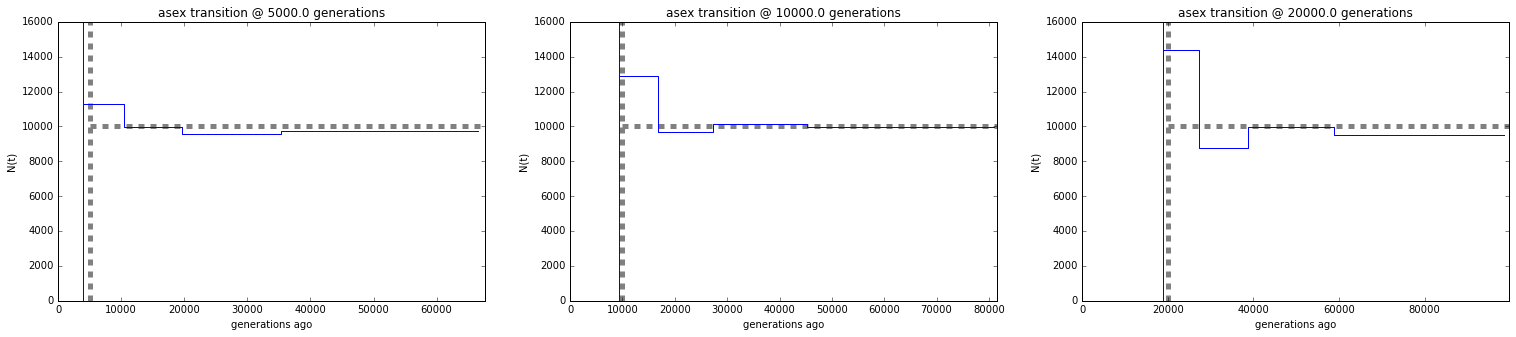

In [29]:
fig, axes = plt.subplots(nrows=1,ncols=len(divtimes), figsize = (26,5))
for colIdx, divtime in enumerate(divtimes):
    axis = axes[colIdx]
    result = results[divtime]
    ts = get_unscaled_ts(result, mu, 100)
    Ns = get_Ns(result, mu, 100)
    divtime *= 2*N
    plot_psmc(axis, trueTs, trueNs, divtime, color='gray', lw=5, ls='dashed', logN = False)
    estimatedDivtime = get_unscaled_divtime(result, mu, 100)
    axis.set_title('asex transition @ {} generations'.format(divtime))
    axis.set_xlabel('generations ago')
    axis.set_ylabel('N(t)')
    axis.set_ylim((0,16000))
    axis.set_xlim((0,max(ts)+divtime))
    plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logN = False)
plt.savefig('const_N_asex_simulations.pdf', dpi=300)

## PSMC 'standard' demographic history with triploid inference

The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

To better reflect our genome (and decrease computation time), I will do simulations of 120Mb instead of 3000Mb:

	ms 3 40 -t 8196 -r 1356 3000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

\begin{align}
\theta &= 4N_0\mu L \\
       &= 4\cdot 28000 \cdot 2.44\cdot 10^{-8} \cdot 3000000\\
       &\approx 8196
\end{align}

In [248]:
trueTs = np.array([0,1120,4200,140000,200000])
trueNs = np.array([28000,1400,14000,28000,28000])
mu = 2.44e-8
r = 4.04e-9
trueN0 = 28000

In [250]:
divtimes = [0.25, 0.5, 1.0]

msStdCmdTriploid = 'mspms 3 40 -t 8196 -r 1356 3000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 -p 12'

addAsexCmds = ["./add_asex.py --triploid - {}".format(divtime) for divtime in divtimes]
ms2tsmcfaCmd = "./ms2psmcfa.py"

filenames = ['triploid_std_demo_asex_{asex}.txt'.format(asex = divtime) for divtime in divtimes]
resultsfilenames = ['triploid_std_demo_asex_{asex}.results'.format(asex = divtime) for divtime in divtimes]

In [251]:
fullCmds = ["{} | {} | {} > {}".format(msStdCmdTriploid, asexCmd, ms2tsmcfaCmd, filename) for asexCmd, filename in zip(addAsexCmds, filenames)]

In [252]:
with open('triploid_std_generation_cmds', 'w') as fout:
    for fullCmd in fullCmds:
        fout.write(fullCmd + '\n')

In [253]:
pattern = '5*4'

In [254]:
analysisCmds = ['stdbuf -o0 -e0 -i0 tsmc/tsmc -p {pattern} -i {iterations} {filename} > {resultsfilename}'.format(
    pattern = pattern,
    iterations = iterations,
    filename = filename,
    resultsfilename = resultsfilename) for filename, resultsfilename in zip(filenames, resultsfilenames)]

In [255]:
with open('triploid_std_analysis_cmds', 'w') as fout:
    for analysisCmd in analysisCmds:
        fout.write(analysisCmd + '\n')

In [256]:
%%bash
#scp triploid_std_*_cmds peter@ammodramus:~/bio/snail/

In [257]:
%%bash
#scp peter@ammodramus:~/bio/snail/triploid_std_demo_asex_{0.25,0.5,1.0}.results .

In [258]:
results = {}
for divtime, resultsfilename in zip(divtimes, resultsfilenames):
    results[divtime] = read_tsmc_results(resultsfilename)
    results[divtime]['truedivtime'] = divtime

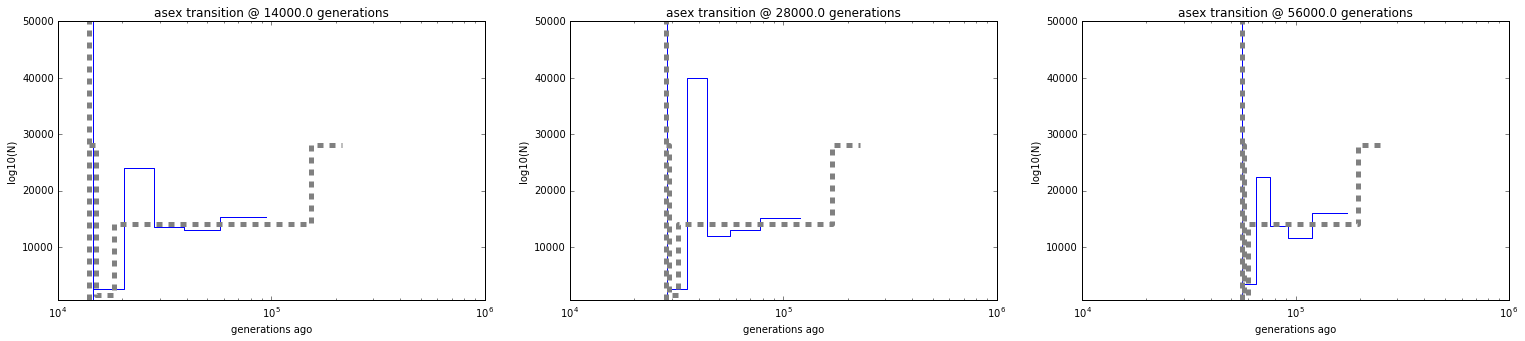

In [260]:
# all lambdas are free, tmax is not
fig, axes = plt.subplots(nrows=1,ncols=len(divtimes), figsize = (26,5))
for colIdx, divtime in enumerate(divtimes):
    axis = axes[colIdx]
    result = results[divtime]
    ts = get_unscaled_ts(result, mu, 100)
    Ns = get_Ns(result, mu, 100)
    divtime *= 2*trueN0
    estimatedDivtime = get_unscaled_divtime(result, mu, 100)
    axis.set_title('asex transition @ {} generations'.format(divtime))
    axis.set_xlabel('generations ago')
    axis.set_ylabel('log10(N)')
    axis.set_ylim((5e2,5e4))
    plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logN = False, logT = True)
    plot_psmc(axis, trueTs, trueNs, divtime = divtime, color='gray', lw=5, ls='dashed', logN = False, logT = True)

## free time

In [261]:
resultsfilenamesFreetime = ['triploid_std_demo_asex_0.25_freetime.results',
 'triploid_std_demo_asex_0.5_freetime.results',
 'triploid_std_demo_asex_1.0_freetime.results']

In [262]:
results = {}
for divtime, resultsfilename in zip(divtimes, resultsfilenamesFreetime):
    results[divtime] = read_tsmc_results(resultsfilename)
    results[divtime]['truedivtime'] = divtime

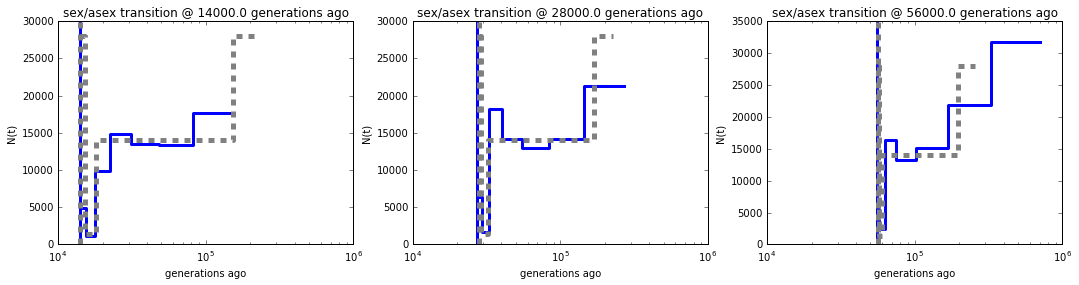

In [267]:
# all lambdas are free, tmax is not
fig, axes = plt.subplots(nrows=1,ncols=len(divtimes), figsize = (18,4))
for colIdx, divtime in enumerate(divtimes):
    axis = axes[colIdx]
    result = results[divtime]
    ts = get_unscaled_ts(result, mu, 100)
    Ns = get_Ns(result, mu, 100)
    divtime *= 2*trueN0
    estimatedDivtime = get_unscaled_divtime(result, mu, 100)
    axis.set_title('sex/asex transition @ {} generations ago'.format(divtime))
    axis.set_xlabel('generations ago')
    axis.set_ylabel('N(t)')
    #axis.set_ylim((1e3,1e5))
    plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=3)
    plot_psmc(axis, trueTs, trueNs, divtime = divtime, color='gray', lw=5, ls='dashed', logT = True, logN = False)

Free time is even better.

## more reps of PSMC std simulation, longer sequence

This time also do no-asex simulations and do 10 reps of each.

## summary
The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

To better reflect our genome (and decrease computation time), I will do simulations of 120Mb instead of 3000Mb:

	ms 3 40 -t 8196 -r 1356 3000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

In [52]:
trueTs = np.array([0,1120,4200,140000,200000])
trueNs = np.array([28000,1400,14000,28000,28000])
mu = 2.44e-8
r = 4.04e-9
trueN0 = 28000

In [61]:
numReps = 10
divtimes = [0.0, 0.25, 0.5, 1.0]

msStdCmdTriploid = 'mspms 3 40 -t 8196 -r 1356 3000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 -p 12'

addAsexCmds = ["./add_asex.py --triploid - {}".format(divtime) for divtime in divtimes]
ms2tsmcfaCmd = "./ms2psmcfa.py"
iterations = 20

mu = 2.44e-8
r = 4.04e-9
trueN0 = 28000

In [62]:
filenames = []
resultsfilenames = []
fullCmds = []
for addAsexCmd, divtime in zip(addAsexCmds, divtimes):
    for rep in range(1,numReps+1):
        filename = 'triploid_std_demo_asex{asex}_rep{rep}.txt'.format(asex = divtime, rep = rep)
        resultsfilename = 'triploid_std_demo_asex{asex}_rep{rep}.results'.format(asex = divtime, rep = rep)
        filenames.append(filename)
        resultsfilenames.append(resultsfilename)
        fullCmds.append("{} | {} | {} > {}".format(msStdCmdTriploid, addAsexCmd, ms2tsmcfaCmd, filename) )

In [63]:
#with open('triploid_std_generation_cmds_more_reps', 'w') as fout:
#    for fullCmd in fullCmds:
#        fout.write(fullCmd + '\n')

In [64]:
analysisCmds = ['stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {datadir}/{filename} > {datadir}/{resultsfilename}'.format(
    datadir = "triploid_std_demo_data",
    iterations = iterations,
    filename = filename,
    resultsfilename = resultsfilename) for filename, resultsfilename in zip(filenames, resultsfilenames)]

In [65]:
#with open('triploid_std_analysis_cmds_more_reps', 'w') as fout:
#    for analysisCmd in analysisCmds:
#        fout.write(analysisCmd + '\n')

In [66]:
%%bash
#scp triploid_std_*_cmds_more_reps peter@ammodramus:~/bio/snail/

In [67]:
def make_odyssey_runfile_std_sim(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_std_sim_asex{asex}_rep{rep}.out
#SBATCH -e tsmc_std_sim_asex{asex}_rep{rep}.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_std_demo_data/triploid_std_demo_asex{asex}_rep{rep}.txt'.format(asex = asex, rep = rep)
    resultsfilepath = 'triploid_std_demo_data/triploid_std_demo_asex{asex}_rep{rep}.results'.format(asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [68]:
#for asex in divtimes:
#    for rep in range(1, numReps+1):
#        runcmdfilename = 'run_std_sim_asex{}_rep{}.sh'.format(asex, rep)
#        with open(runcmdfilename, 'w') as fout:
#            fout.write(make_odyssey_runfile_std_sim(asex,rep)+'\n')

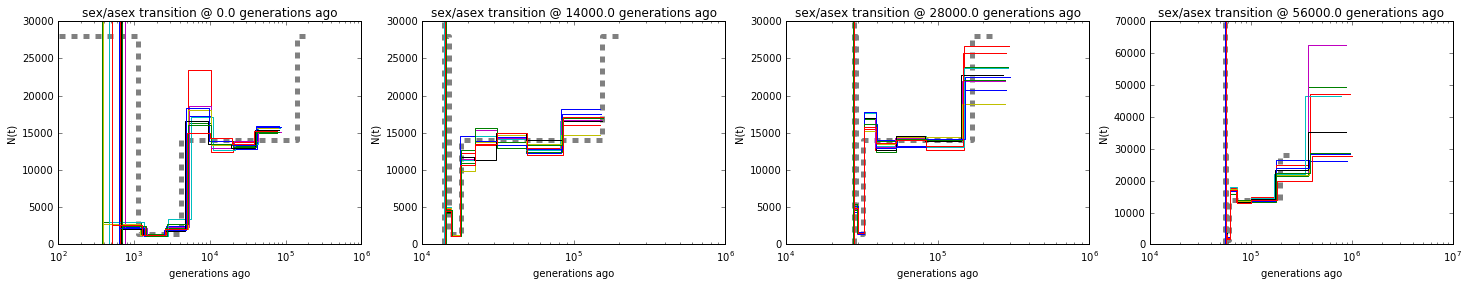

In [72]:
fig, axes = plt.subplots(nrows=1,ncols=len(divtimes), figsize = (25,4))
for asex, axis in zip(divtimes, axes):
    truedivtime = 2*trueN0*asex
    axis.set_title('sex/asex transition @ {} generations ago'.format(truedivtime))
    axis.set_xlabel('generations ago')
    axis.set_ylabel('N(t)')
    plot_psmc(axis, trueTs, trueNs, divtime = truedivtime, color='gray', lw=5, ls='dashed', logT = True, logN = False)
    for rep in range(1, numReps+1):
        resultsfilepath = "{resultsdir}/triploid_std_demo_asex{asex}_rep{rep}.results".format(
            resultsdir =  "triploid_std_demo_data",
            asex = asex,
            rep = rep)
        result = read_tsmc_results(resultsfilepath)
        result['truedivtime'] = divtime
        ts = get_unscaled_ts(result, mu, 100)
        Ns = get_Ns(result, mu, 100)
        estimatedDivtime = get_unscaled_divtime(result, mu, 100)
        plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=1)
        

## Exponential growth

Want to do the same, but with exponential growth. Below is the simulation diploid simulation I did of recent exponential growth:



In [76]:
N0 = 1000000
N1 = 5000
Tgrowth = 100

rescaledN1 = N1 / (4.0*N0)
rescaledTgrowth = Tgrowth / (4.0*N0)
growthRate = np.log(float(N0)/N1) / rescaledTgrowth

mu = 1.5e-8
r = 1.0e-8  # recombination rate
chromLength = int(1e7)  # 10 Mbp per chromosome
numChromosomes = 12  # simulate 120 Mb total

# scaled parameters for entire chromosomes
rho = 4*N0*r*chromLength
theta = 4*N0*mu*chromLength

numReps = 5

# the different transition times to test
asexGens = np.array([2000, 5000, 10000, 20000, 40000])
asexGensRescaled = asexGens / (2.0*N0)  # rescaled by 2*N

trueTs = [0, 100,100000]
trueNs = [1000000, 5000,5000]

In [77]:
msCmd = 'mspms 3 {numChroms} -t {theta} -r {rho} {chromLen} -eG 0 {growthRate} -eN {rescaledTgrowth} {rescaledN1} -p 12'.format(
    numChroms = numChromosomes, theta = theta, rho = rho, chromLen = chromLength, growthRate = growthRate,
    rescaledTgrowth = rescaledTgrowth, rescaledN1 = rescaledN1)
addAsexCmdTemplate = './add_asex.py --triploid - {}'
ms2psmcfaCmd = './ms2psmcfa.py'

In [78]:
asexGens = [0.0, 0.25, 0.5, 1.0]
numReps = 10

In [79]:
exponentialDir = 'triploid_exp_sim_data'
filenameTemplate = '{filedir}/triploid_exp_sim_asex{asex}_rep{rep}.txt'
resultsfilenameTemplate = '{filedir}/triploid_exp_sim_asex{asex}_rep{rep}.results'
expGenerationCmds = []
for asex in asexGens:
    addAsexCmd = addAsexCmdTemplate.format(asex)
    for rep in range(1,numReps+1):
        filename = filenameTemplate.format(filedir = exponentialDir, asex = asex, rep = rep) 
        resultsfilename = resultsfilenameTemplate.format(filedir = exponentialDir, asex = asex, rep = rep) 
        generationCmd = '{} | {} | {} > {}'.format(msCmd, addAsexCmd, ms2psmcfaCmd, filename)
        expGenerationCmds.append(generationCmd)

In [80]:
#with open('triploid_exp_generation_cmds','w') as fout:
#    for cmd in expGenerationCmds:
#        fout.write(cmd + '\n')

In [81]:
%%bash
#scp triploid_exp_generation_cmds peter@ammodramus:~/bio/snail/
# simulated on ammodramus, scp'ed to odyssey

In [82]:
def make_odyssey_runfile_exp_sim(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_exp_sim_asex{asex}_rep{rep}.out
#SBATCH -e tsmc_exp_sim_asex{asex}_rep{rep}.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_exp_sim_data/triploid_exp_sim_asex{asex}_rep{rep}.txt'.format(asex = asex, rep = rep)
    resultsfilepath = 'triploid_exp_sim_data/triploid_exp_sim_asex{asex}_rep{rep}.results'.format(asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [83]:
#for asex in divtimes:
#    for rep in range(1, numReps+1):
#        runcmdfilename = 'run_exp_sim_asex{}_rep{}.sh'.format(asex, rep)
#        with open(runcmdfilename, 'w') as fout:
#            fout.write(make_odyssey_runfile_exp_sim(asex,rep)+'\n')

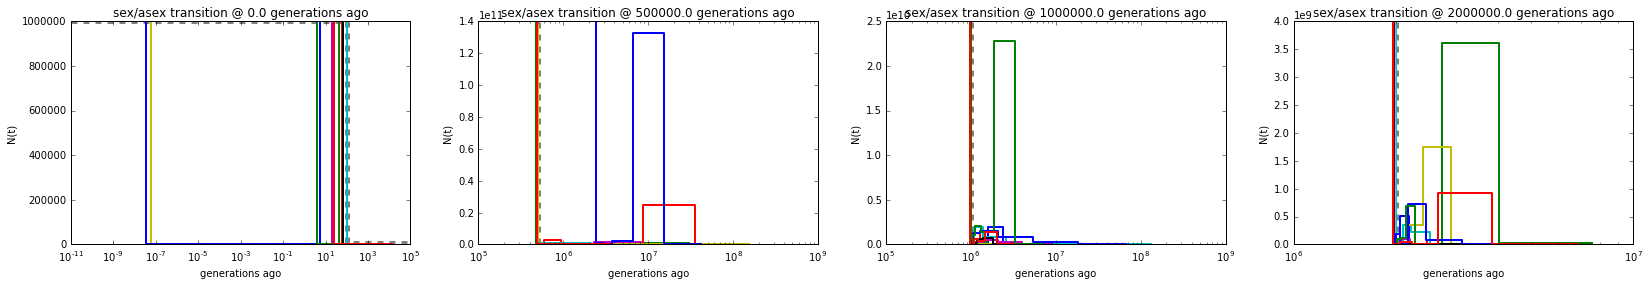

In [87]:
fig, axes = plt.subplots(nrows=1,ncols=len(divtimes), figsize = (28,4))
for asex, axis in zip(divtimes, axes):
    truedivtime = 2*N0*asex
    axis.set_title('sex/asex transition @ {} generations ago'.format(truedivtime))
    axis.set_xlabel('generations ago')
    axis.set_ylabel('N(t)')
    plot_psmc(axis, trueTs, trueNs, divtime = truedivtime, color='gray', lw=5, ls='dashed', logT = True, logN = False)
    for rep in range(1, numReps+1):
        resultsfilepath = "{resultsdir}/triploid_exp_sim_asex{asex}_rep{rep}.results".format(
            resultsdir =  "triploid_exp_sim_data",
            asex = asex,
            rep = rep)
        result = read_tsmc_results(resultsfilepath)
        result['truedivtime'] = divtime
        ts = get_unscaled_ts(result, mu, 100)
        Ns = get_Ns(result, mu, 100)
        estimatedDivtime = get_unscaled_divtime(result, mu, 100)
        plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)
        

The above simulations demonstrate that when the sex-to-asex transition time gets very large, the transition time is inferred well, but the demographic history of the sexual ancestor is lost. This makes sense: lots of Meselson-effect mutations should erode the signature of the sexual ancestor's population history.

## Simulations of different recent transitions

In [63]:
numGens = [0, 100, 200, 400, 800, 1600]  # number of *generations* of asex
numReps = 10
mu = 1.5e-8  # mutation rate
r = 1.0e-8  # recombination rate
N = 10000  # diploid population size in the sexual ancestor
chromLen = int(1e7)  # 10 Mbp per chromosome
numChromosomes = 10  # simulate 10 chromosomes per replicate

trueTs = np.array([0,400000])
trueNs = np.array([N, N])

totalTheta = 4.0*N*mu*chromLen
totalRho = 4.0*N*r*chromLen

In [64]:
# generating the data with mspms

msCmd = "mspms 3 {numChroms} -t {theta} -r {rho} {chromLen} -p 12".format(
    numChroms = numChromosomes,
    theta = totalTheta,
    rho = totalRho,
    chromLen = chromLen
    )
addAsexCmdTemplate = "./add_asex.py --triploid - {divtime}"
ms2tsmcfaCmd = "./ms2psmcfa.py"

# mkdir -p this dir...
resultsDir = "triploid_recent_const_N_data"

_ = '''
with open('triploid_recent_const_N_generation_cmds', 'w') as fout:
    for numGen in numGens:
        rescaledNumGen = float(numGen) / (2.0*N)
        addAsexCmd = addAsexCmdTemplate.format(divtime = rescaledNumGen)
        for rep in range(1, numReps+1):
            datafilename = "triploid_recent_const_N_asex{}_rep{}.txt".format(
                rescaledNumGen, rep)
            runCmd = "{} | {} | {} > {}/{}".format(
                msCmd, addAsexCmd, ms2tsmcfaCmd, resultsDir, datafilename)
            fout.write(runCmd + '\n')
'''

In [65]:
%%bash
#scp triploid_recent_const_N_generation_cmds peter@ammodramus:~/bio/snail/

In [66]:
def make_odyssey_recent_sim(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_recent_sim_asex{asex}_rep{rep}.out
#SBATCH -e tsmc_recent_sim_asex{asex}_rep{rep}.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_recent_const_N_data/triploid_recent_const_N_asex{asex}_rep{rep}.txt'.format(
        asex = asex, rep = rep)
    resultsfilepath = 'triploid_recent_const_N_data/triploid_recent_const_N_asex{asex}_rep{rep}.results'.format(
        asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [67]:
#for numGen in numGens:
#    for rep in range(1, numReps+1):
#        scaledAsex = float(numGen) / (2.0*N)
#        runCmdFilename = "run_recent_const_N_asex{asex}_rep{rep}.sh".format(
#            asex = scaledAsex, rep = rep)
#        with open(runCmdFilename, 'w') as fout:
#            fout.write(make_odyssey_recent_sim(scaledAsex, rep)+'\n')

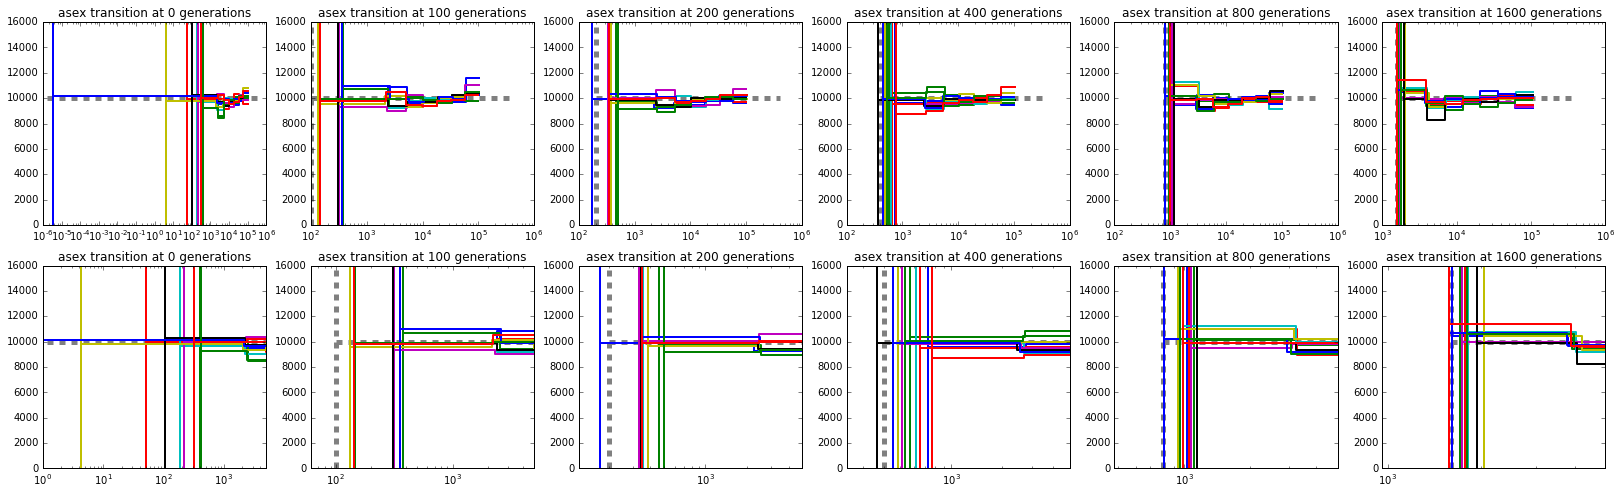

In [68]:
# read in the results
resultsDir = 'triploid_recent_const_N_data'
fig, axes = plt.subplots(nrows=2,ncols=len(numGens), figsize = (28,8))
for asex, axis in zip(numGens, axes[0]):
    rescaledAsex = float(asex) / (2.0 * N)
    plot_psmc(axis, trueTs, trueNs, divtime = asex, logT = True, logN = False, lw = 5, ls = 'dashed', color = 'gray')
    axis.set_ylim((0,16000))
    axis.set_title('asex transition at {} generations'.format(asex))
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_recent_const_N_asex{asex}_rep{rep}.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        result = read_tsmc_results(filename)
        result['truedivtime'] = rescaledAsex
        ts = get_unscaled_ts(result, mu, 100)
        Ns = get_Ns(result, mu, 100)
        estimatedDivtime = get_unscaled_divtime(result, mu, 100)
        plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)
for asex, axis in zip(numGens, axes[1]):
    rescaledAsex = float(asex) / (2.0 * N)
    plot_psmc(axis, trueTs, trueNs, divtime = asex, logT = True, logN = False, lw = 5, ls = 'dashed', color = 'gray')
    axis.set_ylim((0,16000))
    axis.set_xlim((0.6*asex+1,5000))
    if asex > 0.0:
        axis.set_xticks(np.arange(0.9*asex, 5000, step = (5000-0.9*asex)/10))
    axis.set_title('asex transition at {} generations'.format(asex))
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_recent_const_N_asex{asex}_rep{rep}.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        result = read_tsmc_results(filename)
        result['truedivtime'] = rescaledAsex
        ts = get_unscaled_ts(result, mu, 100)
        Ns = get_Ns(result, mu, 100)
        estimatedDivtime = get_unscaled_divtime(result, mu, 100)
        plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)

## Fig. 2 PSMC simulation with recent transitions

### summary
The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

To better reflect our genome (and decrease computation time), I will do simulations of 120Mb instead of 3000Mb:

	ms 3 40 -t 8196 -r 1356 3000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

In [86]:
numReps = 10

trueTs = np.array([0,1120,4200,140000,200000])
trueNs = np.array([28000,1400,14000,28000,28000])

mu = 2.44e-8
r = 4.04e-9

trueN0 = trueNs[0]

numGens = [0, 100, 200, 400, 800, 1600]
numReps = 10

totalTheta = 8196
totalRho = 1356

numChroms = 40
chromLen = 3000000

mu = float(totalTheta)/(chromLen * 4.0 * trueN0)
r = float(totalRho) / (chromLen * 4.0 * trueN0)

In [87]:
msCmd = "mspms 3 {numChroms} -t {totalTheta} -r {totalRho} {chromLen} -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 -p 12".format(
    numChroms = numChroms,
    totalTheta = totalTheta,
    totalRho = totalRho,
    chromLen = chromLen)
addAsexCmdTemplate = './add_asex.py --triploid - {asex}'
ms2tsmcfaCmd = './ms2psmcfa.py'

datadir = 'triploid_std_recent_data'

with open('run_recent_std_cmds', 'w') as fout:
    for numGensAsex in numGens:
        scaledAsex = float(numGensAsex) / (2.0 * trueN0)
        addAsexCmd = addAsexCmdTemplate.format(asex = scaledAsex)
        for rep in range(1, numReps+1):
            datafilename = '{datadir}/triploid_std_recent_asex{asex}_rep{rep}.txt'.format(
                datadir = datadir, asex = scaledAsex, rep = rep)
            wholeCmd = '{} | {} | {} > {}'.format(
                msCmd, addAsexCmd, ms2tsmcfaCmd, datafilename)
            fout.write(wholeCmd + '\n')

In [88]:
%%bash
#scp run_recent_std_cmds peter@ammodramus:~/bio/snail/

In [89]:
def make_odyssey_recent_std_sim(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_recent_std_asex{asex}_rep{rep}.out
#SBATCH -e tsmc_recent_std_asex{asex}_rep{rep}.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_std_recent_data/triploid_std_recent_asex{asex}_rep{rep}.txt'.format(
        asex = asex, rep = rep)
    resultsfilepath = 'triploid_std_recent_data/triploid_std_recent_asex{asex}_rep{rep}.results'.format(
        asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [90]:
#for numGen in numGens:
#    scaledNumGens = numGen / (2.0*trueN0)
#    for rep in range(1,numReps+1):
#        shFilename = 'run_std_recent_asex{asex}_rep{rep}.sh'.format(
#            asex = scaledNumGens, rep = rep)
#        with open(shFilename, 'w') as fout:
#            fout.write(make_odyssey_recent_std_sim(scaledNumGens, rep) + '\n')

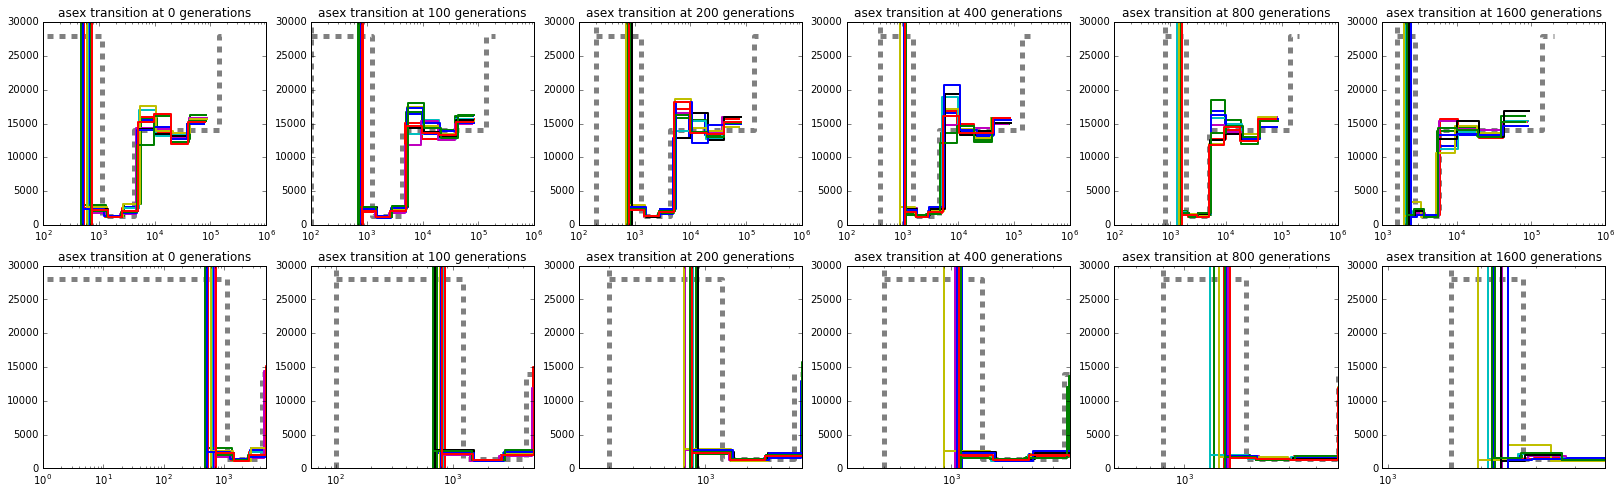

In [96]:
# read in the results
resultsDir = 'triploid_std_recent_data'
fig, axes = plt.subplots(nrows=2,ncols=len(numGens), figsize = (28,8))
for asex, axis in zip(numGens, axes[0]):
    rescaledAsex = float(asex) / (2.0 * trueN0)
    plot_psmc(axis, trueTs, trueNs, divtime = asex, logT = True, logN = False, lw = 5, ls = 'dashed', color = 'gray')
    axis.set_title('asex transition at {} generations'.format(asex))
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_std_recent_asex{asex}_rep{rep}.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        try:
            result = read_tsmc_results(filename)
            result['truedivtime'] = rescaledAsex
            ts = get_unscaled_ts(result, mu, 100)
            Ns = get_Ns(result, mu, 100)
            estimatedDivtime = get_unscaled_divtime(result, mu, 100)
            plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)
        except:
            continue
for asex, axis in zip(numGens, axes[1]):
    rescaledAsex = float(asex) / (2.0 * trueN0)
    plot_psmc(axis, trueTs, trueNs, divtime = asex, logT = True, logN = False, lw = 5, ls = 'dashed', color = 'gray')
    axis.set_xlim((0.6*asex+1,5000))
    axis.set_title('asex transition at {} generations'.format(asex))
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_std_recent_asex{asex}_rep{rep}.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        try:
            result = read_tsmc_results(filename)
            result['truedivtime'] = rescaledAsex
            ts = get_unscaled_ts(result, mu, 100)
            Ns = get_Ns(result, mu, 100)
            estimatedDivtime = get_unscaled_divtime(result, mu, 100)
            plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)
        except:
            continue


## Shorter sequences to see whether sequence length matters

In [5]:
numReps = 10

trueTs = np.array([0,1120,4200,140000,200000])
trueNs = np.array([28000,1400,14000,28000,28000])

mu = 2.44e-8
r = 4.04e-9

trueN0 = trueNs[0]

numGens = [0, 100, 200, 400, 800, 1600]
numReps = 10

totalTheta = 8196
totalRho = 1356

numChroms = 4
chromLen = 3000000

mu = float(totalTheta)/(chromLen * 4.0 * trueN0)
r = float(totalRho) / (chromLen * 4.0 * trueN0)

In [6]:
msCmd = "mspms 3 {numChroms} -t {totalTheta} -r {totalRho} {chromLen} -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 -p 12".format(
    numChroms = numChroms,
    totalTheta = totalTheta,
    totalRho = totalRho,
    chromLen = chromLen)
addAsexCmdTemplate = './add_asex.py --triploid - {asex}'
ms2tsmcfaCmd = './ms2psmcfa.py'

datadir = 'triploid_std_recent_data_shorter'

with open('run_recent_std_shorter_cmds', 'w') as fout:
    for numGensAsex in numGens:
        scaledAsex = float(numGensAsex) / (2.0 * trueN0)
        addAsexCmd = addAsexCmdTemplate.format(asex = scaledAsex)
        for rep in range(1, numReps+1):
            datafilename = '{datadir}/triploid_std_recent_asex{asex}_rep{rep}_shorter.txt'.format(
                datadir = datadir, asex = scaledAsex, rep = rep)
            wholeCmd = '{} | {} | {} > {}'.format(
                msCmd, addAsexCmd, ms2tsmcfaCmd, datafilename)
            fout.write(wholeCmd + '\n')

In [7]:
%%bash
#scp run_recent_std_shorter_cmds peter@ammodramus:~/bio/snail/

In [8]:
def make_odyssey_recent_std_sim_shorter(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_recent_std_asex{asex}_rep{rep}.out
#SBATCH -e tsmc_recent_std_asex{asex}_rep{rep}.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_std_recent_data_shorter/triploid_std_recent_asex{asex}_rep{rep}_shorter.txt'.format(
        asex = asex, rep = rep)
    resultsfilepath = 'triploid_std_recent_data/triploid_std_recent_asex{asex}_rep{rep}_shorter.results'.format(
        asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [9]:
for numGen in numGens:
    scaledNumGens = numGen / (2.0*trueN0)
    for rep in range(1,numReps+1):
        shFilename = 'run_std_recent_asex{asex}_rep{rep}_shorter.sh'.format(
            asex = scaledNumGens, rep = rep)
        with open(shFilename, 'w') as fout:
            fout.write(make_odyssey_recent_std_sim_shorter(scaledNumGens, rep) + '\n')

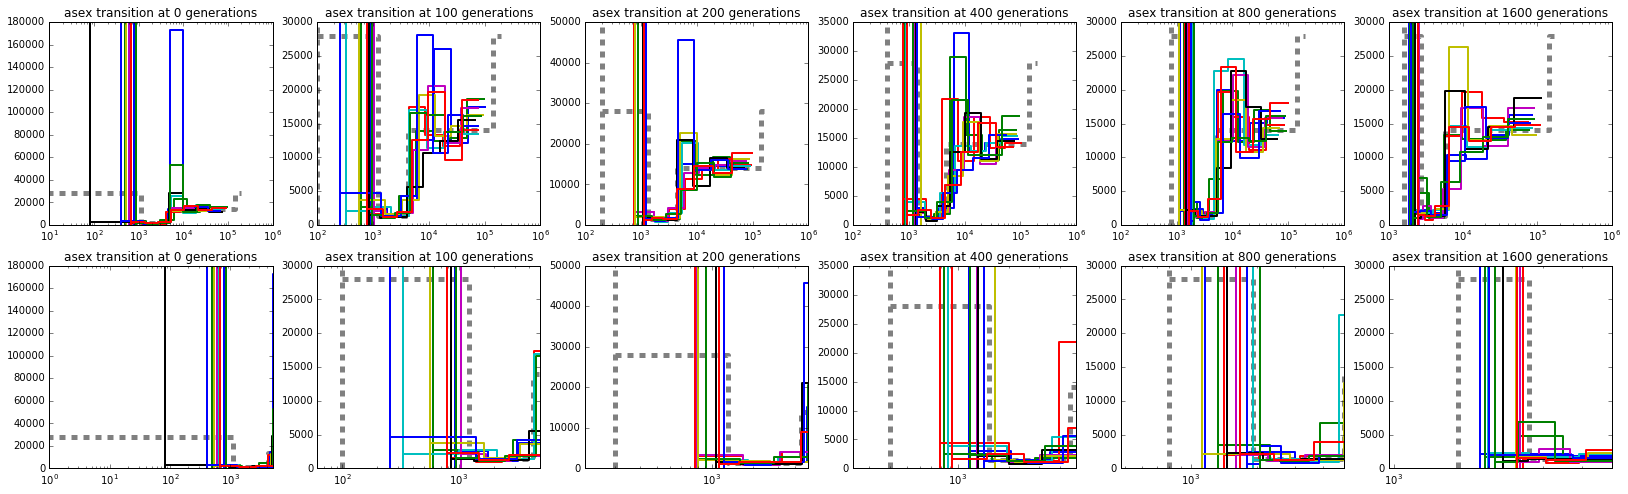

In [21]:
# run this when results are retrieved...

# read in the results
resultsDir = 'triploid_std_recent_data_shorter'
fig, axes = plt.subplots(nrows=2,ncols=len(numGens), figsize = (28,8))
for asex, axis in zip(numGens, axes[0]):
    rescaledAsex = float(asex) / (2.0 * trueN0)
    plot_psmc(axis, trueTs, trueNs, divtime = asex, logT = True, logN = False, lw = 5, ls = 'dashed', color = 'gray')
    axis.set_title('asex transition at {} generations'.format(asex))
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_std_recent_asex{asex}_rep{rep}_shorter.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        try:
            result = read_tsmc_results(filename)
            result['truedivtime'] = rescaledAsex
            ts = get_unscaled_ts(result, mu, 100)
            Ns = get_Ns(result, mu, 100)
            estimatedDivtime = get_unscaled_divtime(result, mu, 100)
            plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)
        except:
            continue
for asex, axis in zip(numGens, axes[1]):
    rescaledAsex = float(asex) / (2.0 * trueN0)
    plot_psmc(axis, trueTs, trueNs, divtime = asex, logT = True, logN = False, lw = 5, ls = 'dashed', color = 'gray')
    axis.set_xlim((0.6*asex+1,5000))
    axis.set_title('asex transition at {} generations'.format(asex))
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_std_recent_asex{asex}_rep{rep}_shorter.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        try:
            result = read_tsmc_results(filename)
            result['truedivtime'] = rescaledAsex
            ts = get_unscaled_ts(result, mu, 100)
            Ns = get_Ns(result, mu, 100)
            estimatedDivtime = get_unscaled_divtime(result, mu, 100)
            plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)
        except:
            continue


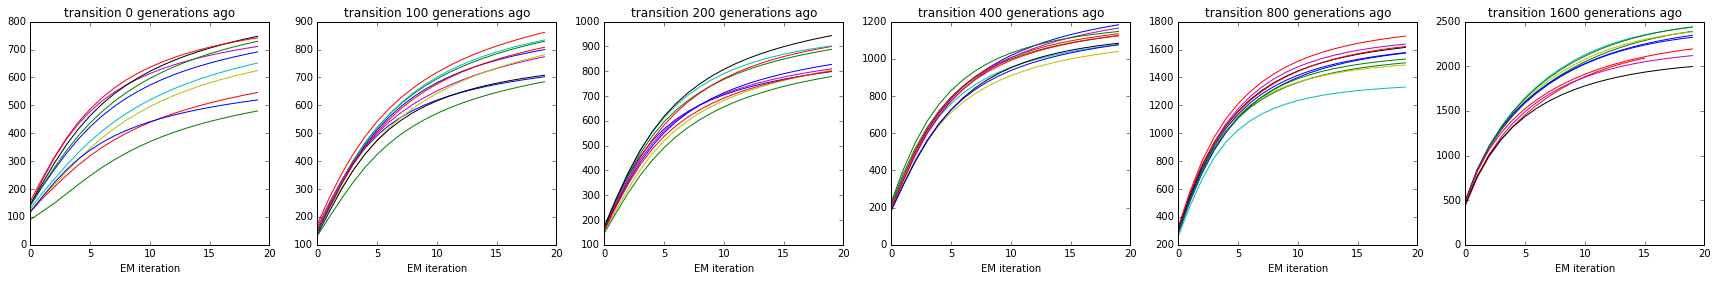

In [41]:
# checking the convergence

# read in the results
resultsDir = 'triploid_std_recent_data'
fig, axes = plt.subplots(nrows=1,ncols=len(numGens), figsize = (30,4))
for asex, axis in zip(numGens, axes):
    rescaledAsex = float(asex) / (2.0 * trueN0)
    axis.set_title('transition {} generations ago'.format(asex))
    axis.set_xlabel('EM iteration')
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_std_recent_asex{asex}_rep{rep}.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        convergence = read_tsmc_convergence(filename)
        divtimes = np.array(convergence['divtime'])
        lam0s = np.array(convergence['lambda0'])
        thetas = np.array(convergence['theta'])
        N0s = lam0s * thetas / (4.0*mu*100)
        unscaledDivtimes = divtimes * 2.0 * N0s
        axis.plot(unscaledDivtimes)

## Longer sequences again, with longer period before bottleneck.

### summary
The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Original changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

I want the first change in population size at 20000 generations, which corresponds to 

    mspms 3 40 -t 81960 -r 13560 3000000 -eN 0.1785714 0.05 -eN 0.2060714 0.5 -eN 1.4185714 1 -p 12

In [47]:
numReps = 10

trueTs = np.array([0,20000,4200+20000-1120,140000+20000-1120,200000+20000-1120])
trueNs = np.array([28000,1400,14000,28000,28000])

mu = 2.44e-8
r = 4.04e-9

trueN0 = trueNs[0]

numGens = [0, 100, 200, 400, 800, 1600]
numReps = 10

totalTheta = 8196
totalRho = 1356

numChroms = 40
chromLen = 3000000

mu = float(totalTheta)/(chromLen * 4.0 * trueN0)
r = float(totalRho) / (chromLen * 4.0 * trueN0)

In [48]:
msCmd = "mspms 3 {numChroms} -t {totalTheta} -r {totalRho} {chromLen} -eN 0.1785714 0.05 -eN 0.2060714 0.5 -eN 1.4185714 1 -p 12".format(
    numChroms = numChroms,
    totalTheta = totalTheta,
    totalRho = totalRho,
    chromLen = chromLen)
addAsexCmdTemplate = './add_asex.py --triploid - {asex}'
ms2tsmcfaCmd = './ms2psmcfa.py'

datadir = 'triploid_std_recent_extended_data'

with open('run_recent_std_extended_cmds', 'w') as fout:
    for numGensAsex in numGens:
        scaledAsex = float(numGensAsex) / (2.0 * trueN0)
        addAsexCmd = addAsexCmdTemplate.format(asex = scaledAsex)
        for rep in range(1, numReps+1):
            datafilename = '{datadir}/triploid_std_recent_asex{asex}_rep{rep}_extended.txt'.format(
                datadir = datadir, asex = scaledAsex, rep = rep)
            wholeCmd = '{} | {} | {} > {}'.format(
                msCmd, addAsexCmd, ms2tsmcfaCmd, datafilename)
            fout.write(wholeCmd + '\n')

In [49]:
%%bash
#scp run_recent_std_extended_cmds peter@ammodramus:~/bio/snail/

In [50]:
def make_odyssey_recent_std_sim_extended(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_recent_std_asex{asex}_rep{rep}_extended.out
#SBATCH -e tsmc_recent_std_asex{asex}_rep{rep}_extended.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_std_recent_extended_data/triploid_std_recent_asex{asex}_rep{rep}_extended.txt'.format(
        asex = asex, rep = rep)
    resultsfilepath = 'triploid_std_recent_extended_data/triploid_std_recent_asex{asex}_rep{rep}_extended.results'.format(
        asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [51]:
for numGen in numGens:
    scaledNumGens = numGen / (2.0*trueN0)
    for rep in range(1,numReps+1):
        shFilename = 'run_std_recent_asex{asex}_rep{rep}_extended.sh'.format(
            asex = scaledNumGens, rep = rep)
        with open(shFilename, 'w') as fout:
            fout.write(make_odyssey_recent_std_sim_extended(scaledNumGens, rep) + '\n')

In [52]:
%%bash
#tar -zcf run_std_recent_extended_cmds.tar.gz run_*extended.sh
#rm run_*extended.sh

## Standard PSMC simulation with more contiguity

In [62]:
numReps = 10

trueTs = np.array([0,1120,4200,140000,200000])
trueNs = np.array([28000,1400,14000,28000,28000])

mu = 2.44e-8
r = 4.04e-9

trueN0 = trueNs[0]

numGens = [0, 100, 200, 400, 800, 1600]
numReps = 5

numChroms = 2
chromLen = int(120e6/numChroms)

totalTheta = 4.0 * chromLen * mu * trueN0
totalRho = 4.0 * chromLen * r * trueN0

In [63]:
msCmd = "mspms 3 {numChroms} -t {totalTheta} -r {totalRho} {chromLen} -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 -p 12".format(
    numChroms = numChroms,
    totalTheta = totalTheta,
    totalRho = totalRho,
    chromLen = chromLen)
addAsexCmdTemplate = './add_asex.py --triploid - {asex}'
ms2tsmcfaCmd = './ms2psmcfa.py'

datadir = 'triploid_std_recent_data_contiguous'

with open('run_recent_std_contiguous_cmds', 'w') as fout:
    for numGensAsex in numGens:
        scaledAsex = float(numGensAsex) / (2.0 * trueN0)
        addAsexCmd = addAsexCmdTemplate.format(asex = scaledAsex)
        for rep in range(1, numReps+1):
            datafilename = '{datadir}/triploid_std_recent_asex{asex}_rep{rep}_contiguous.txt'.format(
                datadir = datadir, asex = scaledAsex, rep = rep)
            wholeCmd = '{} | {} | {} > {}'.format(
                msCmd, addAsexCmd, ms2tsmcfaCmd, datafilename)
            fout.write(wholeCmd + '\n')

In [64]:
def make_odyssey_recent_std_sim_contiguous(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_recent_std_asex{asex}_rep{rep}_contiguous.out
#SBATCH -e tsmc_recent_std_asex{asex}_rep{rep}_contiguous.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_std_recent_data_contiguous/triploid_std_recent_asex{asex}_rep{rep}_contiguous.txt'.format(
        asex = asex, rep = rep)
    resultsfilepath = 'triploid_std_recent_data_contiguous/triploid_std_recent_asex{asex}_rep{rep}_contiguous.results'.format(
        asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [65]:
for numGen in numGens:
    scaledNumGens = numGen / (2.0*trueN0)
    for rep in range(1,numReps+1):
        shFilename = 'run_std_recent_asex{asex}_rep{rep}_contiguous.sh'.format(
            asex = scaledNumGens, rep = rep)
        with open(shFilename, 'w') as fout:
            fout.write(make_odyssey_recent_std_sim_contiguous(scaledNumGens, rep) + '\n')

In [66]:
%%bash
#tar -zcf run_std_recent_contiguous_cmds.tar.gz run_*contiguous.sh
#rm run_*contiguous.sh